In [1]:
import sys
sys.path.append("/home/raulteixeira/repos/CSPZ/scripts/")
import NoiseSOM as ns
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import time
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

In [2]:
plt.rc('font', family="serif")
plt.rc('font', size=12)
plt.rc('text', usetex=False)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #necessary to use \dfrac
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [3]:
n = 48 # size of SOM
path_data = "/project2/chihway/raulteixeira/data/"
som_weights = np.load("%s/som_deep_48_48_5e5.npy"%path_data,allow_pickle=True)

nTrain=5e5
hh = ns.hFunc(nTrain,sigma=(30,1))
metric = ns.AsinhMetric(lnScaleSigma=0.4,lnScaleStep=0.03)
som = ns.NoiseSOM(metric,None,None, \
    learning=hh, \
    shape=(48,48), \
    wrap=False,logF=True, \
    initialize=som_weights, \
    minError=0.02)

In [4]:
start_time = time.time()

def flux2mag(flux):
    return -2.5 * np.log10(flux) + 30


df = pd.read_table(path_data+'deepfields.csv.gz', sep=',', header=0)


# Mask flagged regions
mask = df.MASK_FLAGS_NIR==0
mask &= df.MASK_FLAGS==0
mask &= df.FLAGS_NIR==0
mask &= df.FLAGS==0
mask &= df.FLAGSTR=="b'ok'"
mask &= df.FLAGSTR_NIR=="b'ok'"
df = df[mask]
df = df.drop(columns=[
    "MASK_FLAGS",
    "MASK_FLAGS_NIR",
    "FLAGS",
    "FLAGS_NIR",
    "FLAGSTR",
    "FLAGSTR_NIR",
])

deep_bands_ = ["U","G","R","I","Z","J","H","KS"]
# remove crazy colors, defined as two 
# consecutive colors (e.g u-g, g-r, r-i, etc) 
# that have a value smaler than -1
mags_d = np.zeros((len(df),len(deep_bands_)))
magerrs_d = np.zeros((len(df),len(deep_bands_)))

for i,band in enumerate(deep_bands_):
    mags_d[:,i] = flux2mag(df['BDF_FLUX_DERED_CALIB_%s'%band])

colors = np.zeros((len(df),len(deep_bands_)-1))
for i in range(len(deep_bands_)-1):
    colors[:,i] = mags_d[:,i] - mags_d[:,i+1]

normal_colors = np.mean(colors > -1, axis=1) == 1
normal_colors.sum()

df = df[normal_colors]

# mask faint objects, i < 25
df = df[flux2mag(df.BDF_FLUX_DERED_CALIB_I.values) < 25]

i = flux2mag(df.BDF_FLUX_DERED_CALIB_I.values)
r = flux2mag(df.BDF_FLUX_DERED_CALIB_R.values)
z = flux2mag(df.BDF_FLUX_DERED_CALIB_Z.values)
k = flux2mag(df.BDF_FLUX_DERED_CALIB_KS.values)

# mask stars based on (z−K) > 0.5×(r −z) color cut

df = df[(z-k) > 0.5*(r-z)]

deep_data=df

deep_data.loc[:,"BDF_MAG_DERED_CALIB_I"]=flux2mag(deep_data.loc[:, 'BDF_FLUX_DERED_CALIB_I'])

def balrog_sigmoid(x, x0):
    """Sigmoid function
    Parameters
    ----------
    x : float or array-like
        Points at which to evaluate the function.
    x0 : float or array-like
        Location of transition.
    Returns
    -------
    sigmoid : scalar or array-like, same shape as input
    """
    return 1.0 - 1.0 / (1.0 + np.exp(-4.0 * (x - x0)))

def mock_balrog_sigmoid(
    deep_data, 
    sigmoid_x0,
    N,
    ref_mag_col = "BDF_MAG_DERED_CALIB_I"
):
    """
    Function for selecting deep field galaxies at a rate that follows a sigmoid function that smoothly transitions from 1 for bright objects, to a value of 0 for faint objects. 
    Parameters
    ----------
    deep_data : pandas dataframe
        Pandas dataframe containing the deep field data.
    sigmoid_x0 : float
        Magnitude value at which the sigmoid function transitions from 1 to 0.
    N : int
        Number of galaxies to be drawn.
    ref_mag_col : string
        Column name of the reference magnitude in deep_data
    Returns
    -------
    deep_balrog_selection : pandas dataframe
        Pandas dataframe containing a list of N deep field objects to be injected by Balrog.
    """
    np.random.seed()
    mag_ref = deep_data.loc[:, ref_mag_col].values
    weights = balrog_sigmoid(mag_ref, sigmoid_x0)
    weights/=sum(weights)
    selected_objects = np.random.choice(len(deep_data), N, p=weights, replace=True)
    
    deep_balrog_selection = deep_data.iloc[selected_objects]
    return deep_balrog_selection

nTrain = int(5e5)
deep_balrog_mocked = mock_balrog_sigmoid(deep_data, 23.0, nTrain)

bands = ['U','G','R','I','Z','J','H','KS']
fluxes_d = np.zeros((len(deep_balrog_mocked),len(bands)))
fluxerrs_d = np.zeros((len(deep_balrog_mocked),len(bands)))

for i,band in enumerate(bands):
    fluxes_d[:,i] = deep_balrog_mocked['BDF_FLUX_DERED_CALIB_%s'%band]
    fluxerrs_d[:,i] = deep_balrog_mocked['BDF_FLUX_ERR_DERED_CALIB_%s'%band]

print("--- %s seconds ---" % (time.time() - start_time))

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


--- 18.191896677017212 seconds ---


In [5]:
data = pd.read_csv('%s/deep_fields_nice_n_z.csv.gz'%path_data)

In [7]:
def good_len(a):
    """
    returns number of non nan values
    """
    return np.sum(~np.isnan(a))
    
features = ['i', 'u-g', 'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'good_Z', 'Z', 'zspec', 'paus_z', 'cosmos_z']
squares = {feat: (data[[feat, 'cells']].groupby('cells').agg(['mean', 'median', 'std', len, good_len]))[feat] for feat in features}

In [8]:
# getting p(z|C)
start_time = time.time()
list_posteriors = []

z_sample_cells = [data['Z'][data['cells'].values==cell_no].values for cell_no in range(n**2)]
z_counts = squares['Z']['len'].values
p_C = z_counts/np.sum(z_counts) #capital C is c-hat #WRONG< use total objects, not just the ones we have spectra
ln_p_C = np.full_like(p_C, -300)
ln_p_C[p_C>0]=np.log(p_C[p_C>0])

z_sample_cells_clean = [z_sample_cell[~np.isnan(z_sample_cell)] for z_sample_cell in z_sample_cells]
bin_info = [np.histogram(z_sample_cell, bins='auto', density=True) for z_sample_cell in z_sample_cells_clean]
bins_v, bins_e = np.array(bin_info)[:,0], np.array(bin_info)[:,1]

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [20]:
x = [0]*len(bins_c)

In [29]:
bin_c

[0.373]

In [35]:
(np.interp(np.linspace(0,3.5,100), bin_c, bin_v, left=0, right=0)==np.zeros(100)).all()

True

In [ ]:
#bins of 0.05 between 0 and 3, constant for all cells

In [18]:
bins = np.arange(0., 3.05, 0.05)
P_z_Cs = np.array([np.histogram(z_C, bins=bins) for z_C in z_sample_cells])

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


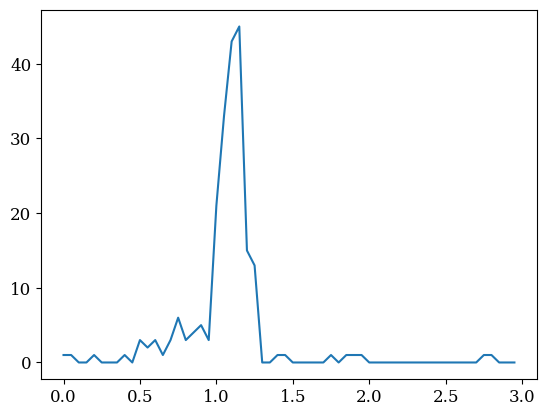

In [36]:
i=2
plt.plot(P_z_Cs[i][1][:-1], P_z_Cs[i][0])

In [8]:
# from scipy.interpolate import CubicSpline
# from scipy.interpolate import interp1d

# n_est = 1000

# bins_c = []
# for i, bins in enumerate(bins_e):
#     bin_c = [bins[i]+.5*(bins[i+1]-bins[i]) for i in range(len(bins)-1)]
#     bins_c.append(bin_c)

# #p_z_Cs = np.array([np.interp(np.linspace(0,3.5,100), bin_c, bin_v, left=0, right=0)\
# #                   for (bin_c, bin_v) in zip(bins_c, bins_v)])

# P_z_Cs = [0]*len(bins_c) #[CubicSpline(bin_c, bin_v, extrapolate=False) for (bin_c, bin_v) in zip(bins_c, bins_v)]
# for i, (bin_c, bin_v) in enumerate(zip(bins_c, bins_v)):
#     if len(bin_c)>=2:
#         P_z_Cs[i] = CubicSpline(bin_c, bin_v, extrapolate=False)
#     else:
#         P_z_Cs[i] = lambda a : a * np.zeros(n_est)
    
# #p_z_Cs = np.array([np.zeros(100) for p_z_C in P_z_Cs])
# p_z_Cs = np.array([P_z_C(np.linspace(0,3.5,n_est)) for P_z_C in P_z_Cs])
# p_z_Cs  = np.where(np.isnan(p_z_Cs)|(p_z_Cs<0), 0, p_z_Cs)

In [57]:
p_z_Cs/=np.sum(p_z_Cs, axis=1).reshape(n**2,1)
p_z_Cs  = np.where(np.isnan(p_z_Cs)|(p_z_Cs<0), 0, p_z_Cs)

In [14]:
len(bins_c)

2304

In [9]:
start_time = time.time()
ln_p_z_Cs = np.full_like(p_z_Cs, -300)
ln_p_z_Cs[p_z_Cs>0]=np.log(p_z_Cs[p_z_Cs>0])

prior = p_C.reshape(n**2,1)*p_z_Cs
prior /= np.sum(prior)

lnpriors = np.full_like(prior, -300)
lnpriors[prior>0] = np.log(prior[prior>0])
lnprior = np.sum(lnpriors, axis=0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.0966494083404541 seconds ---


Text(0, 0.5, 'prior')

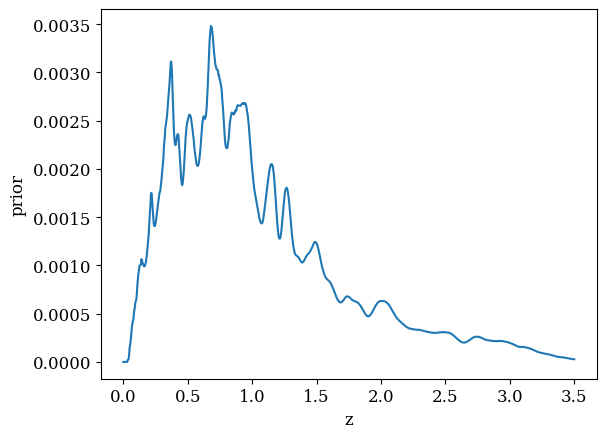

In [10]:
plt.plot(np.linspace(0,3.5,n_est), np.sum(prior,axis=0))
plt.xlabel(r'z')
plt.ylabel(r'prior')

In [ ]:
index = np.random.randint(0, int(5e5))
chi2 = som.chisq(fluxes_d[index], fluxerrs_d[index])


In [18]:
z_sample_cells_good = [z_sample_cell[~np.isnan(z_sample_cell)] for z_sample_cell in z_sample_cells]

In [11]:
#Create chi2 with euclidean metric

In [85]:
start_time = time.time()
list_posteriors = []
for index in np.random.randint(0, int(5e5), 1):

    chi2 = som.chisq(fluxes_d[index], fluxerrs_d[index])

    posteriors = np.exp(lnpriors - .5*chi2)
    posterior = np.sum(posteriors, axis=0)
    posterior /= np.sum(posteriors)
    
    if np.isnan(posterior).any(): continue
    else: list_posteriors.append(posterior)

Nz = np.sum(list_posteriors, axis=0)
print("--- %s seconds ---" % (time.time() - start_time))

/software/python-anaconda-2020.02-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == "__main__":


--- 1355.1692316532135 seconds ---


In [123]:
len(list_posteriors)

9742

In [128]:
np.random.randint(0, 9742, 1)

array([1789])

In [308]:
plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,3.5,n_est), list_posteriors[int(index)])#np.random.randint(0, 9742)])
plt.xlabel(r'z')
plt.ylabel(r'posterior')
plt.show()

IndexError: list index out of range

<Figure size 500x500 with 0 Axes>

Text(0, 0.5, 'N(z)')

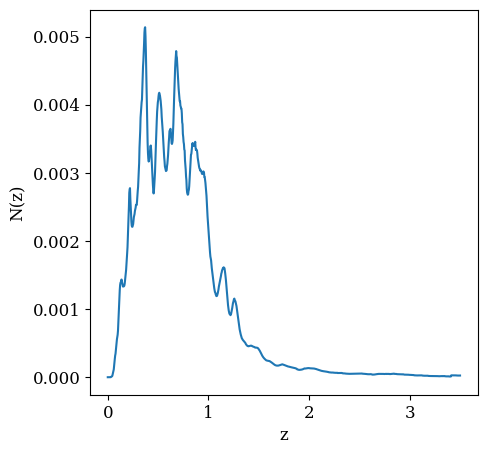

In [171]:
#don't do this, stack histograms instead

plt.figure(figsize=(5,5))
plt.plot(np.linspace(0,3.5,n_est), Nz/sum(Nz))
plt.xlabel(r'z')
plt.ylabel(r'N(z)')
#np.sum(list_posteriors,axis=0))#np.exp(lnprior)/np.sum(np.exp(lnprior)))

In [205]:
CDFs

array([[2.77163475e-126, 5.54326950e-126, 8.31490425e-126, ...,
        9.98460816e-001, 9.99227046e-001, 1.00000000e+000],
       [4.97829922e-127, 9.95659845e-127, 1.49348977e-126, ...,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
       [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000],
       ...,
       [2.09392512e-126, 4.18785024e-126, 6.28177535e-126, ...,
        9.99999885e-001, 9.99999942e-001, 1.00000000e+000],
       [1.77415307e-127, 3.54830614e-127, 5.32245922e-127, ...,
        9.99999999e-001, 9.99999999e-001, 1.00000000e+000],
       [5.72520728e-128, 1.14504146e-127, 1.71756218e-127, ...,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000]])

In [41]:
deep_data.columns

Index(['ID', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I'],
      dtype='object')

In [211]:
np.array(list_posteriors).size

9742000

In [215]:
samplemasks.shape

(9742, 1000)

In [310]:
%%time
seed=42
nsamples = 100000
sampling_rng = np.random.default_rng(seed)
zs = np.linspace(0,3.5,n_est)
samplemasks = np.array(list_posteriors)>1.e-14

CDFs = np.cumsum(list_posteriors, axis=1)
ITSs = [CubicSpline(CDF[samplemask], zs[samplemask], extrapolate=True)\
        for (samplemask, CDF) in zip(samplemasks, CDFs)]
rnumbers = [sampling_rng.uniform(cdf[0], cdf[-1], size=nsamples) for cdf in CDFs]
rzs = [ITS(rn) for (ITS, rn) in zip(ITSs, rnumbers)]

CPU times: user 1min 14s, sys: 11.7 s, total: 1min 25s
Wall time: 1min 25s


In [311]:
np.array(rzs).shape

(9742, 100000)

In [312]:
zlims = [(0.2, 0.43), (0.43, 0.63), (0.63, 0.9), (0.9, 1.3)]

mean_zs = np.mean(rzs, axis=1)
tomo_masks = [(zmin<mean_zs)&(mean_zs<zmax) for (zmin, zmax) in zlims]

In [313]:
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'][:4])[[0, 2, 3, 1]]

7698


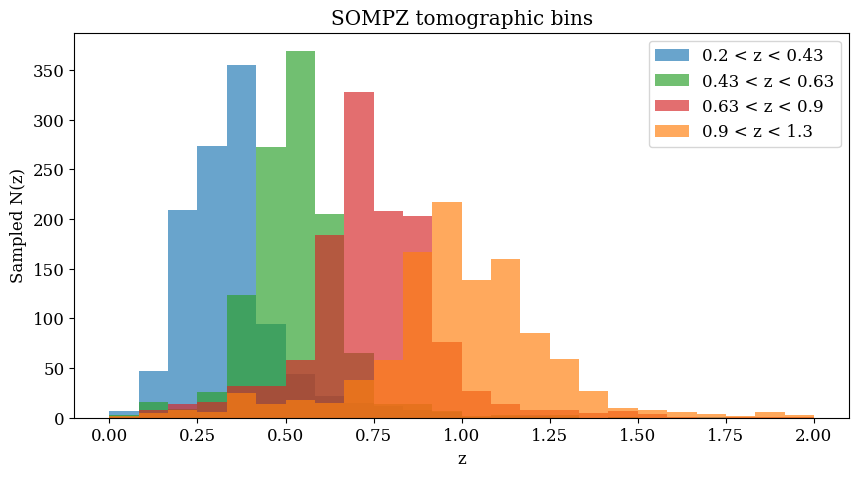

In [314]:
rint = 7698 #np.random.randint(0, 1e4)
print(rint)
tomo_zs = [np.array(rzs)[:,rint][tomo_mask] for tomo_mask in tomo_masks]
plt.figure(figsize=(10,5))
plt.title('SOMPZ tomographic bins')
for i, tomo_z in enumerate(tomo_zs):
    plt.hist(tomo_z, bins=np.linspace(0, 2, 25), alpha=.67,\
             label=f'{zlims[i][0]} < z < {zlims[i][1]}', color = colors[i])

plt.xlabel(r'z')
plt.ylabel(r'Sampled N(z)')
plt.legend()
plt.show()

644


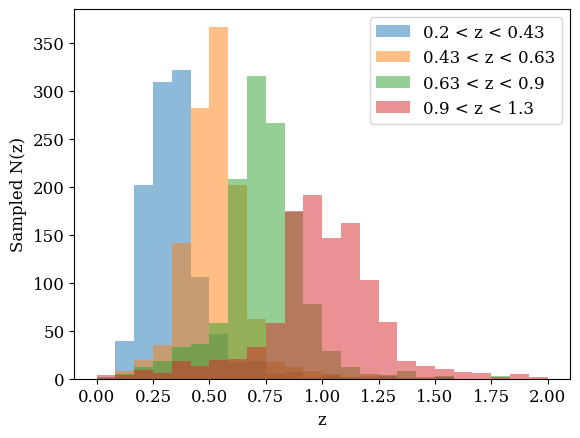

In [281]:
rint = np.random.randint(0, 1e4)
print(rint)
tomo_zs = [np.array(rzs)[:,rint][tomo_mask] for tomo_mask in tomo_masks]
for i, tomo_z in enumerate(tomo_zs):
    plt.hist(tomo_z, bins=np.linspace(0, 2, 25), alpha=.5,\
             label=f'{zlims[i][0]} < z < {zlims[i][1]}')#, color = 'dodgerblue')

plt.xlabel(r'z')
plt.ylabel(r'Sampled N(z)')
plt.legend()
plt.show()

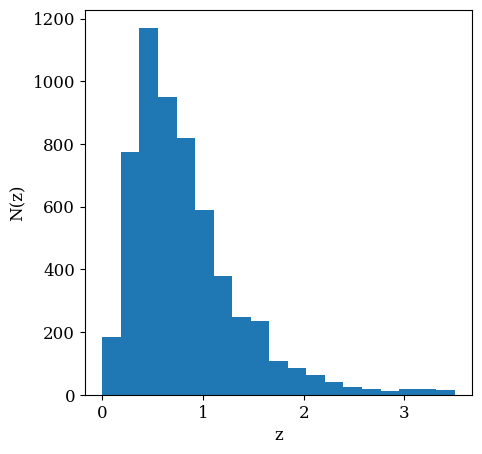

In [244]:
plt.figure(figsize=(5,5))
plt.hist(np.mean(rzs, axis=1), bins=np.linspace(0, 3.5, 20))
plt.xlabel(r'z')
plt.ylabel(r'N(z)')
plt.show()

In [49]:
griz=[flux2mag(data[f'BDF_FLUX_DERED_CALIB_{band}']) for band in ['G', 'R', 'I', 'Z']]

In [140]:
for i, band in enumerate(['g','r', 'i', 'z']):
    data[band]=griz[i]

In [141]:
for i, color in enumerate(['g-i', 'r-i', 'i-z']):
    data[color]=data[color[0]]-data[color[-1]]

In [143]:
data.columns

Index(['Unnamed: 0', 'ID', 'RA', 'DEC', 'KNN_CLASS', 'BDF_FLUX_DERED_CALIB_U',
       'BDF_FLUX_DERED_CALIB_G', 'BDF_FLUX_DERED_CALIB_R',
       'BDF_FLUX_DERED_CALIB_I', 'BDF_FLUX_DERED_CALIB_Z',
       'BDF_FLUX_DERED_CALIB_J', 'BDF_FLUX_DERED_CALIB_H',
       'BDF_FLUX_DERED_CALIB_KS', 'BDF_FLUX_ERR_DERED_CALIB_U',
       'BDF_FLUX_ERR_DERED_CALIB_G', 'BDF_FLUX_ERR_DERED_CALIB_R',
       'BDF_FLUX_ERR_DERED_CALIB_I', 'BDF_FLUX_ERR_DERED_CALIB_Z',
       'BDF_FLUX_ERR_DERED_CALIB_J', 'BDF_FLUX_ERR_DERED_CALIB_H',
       'BDF_FLUX_ERR_DERED_CALIB_KS', 'BDF_MAG_DERED_CALIB_I', 'cells', 'u-g',
       'g-r', 'r-i', 'i-z', 'z-J', 'J-H', 'H-KS', 'i', 'u-i', 'g-i', 'z-i',
       'j-i', 'h-i', 'ks-i', 'zspec', 'paus_z', 'cosmos_z', 'Z', 'good_Z', 'G',
       'R', 'I', 'g', 'r', 'z'],
      dtype='object')

In [50]:
for i, band in enumerate(['G', 'R', 'I', 'Z']):
    data[band] = griz[i]

In [144]:
color_squares = {feat: (data[[feat, 'cells']].groupby('cells').\
                      agg(['mean', 'median', 'std', len, good_len]))[feat] for feat in ['i', 'g-i', 'r-i', 'i-z']}

In [164]:
mag_squares['i']['mean'] = color_squares['i']['mean']
mag_squares['g']['mean'] = color_squares['i']['mean'] + color_squares['g-i']['mean']
mag_squares['r']['mean'] = color_squares['i']['mean'] + color_squares['r-i']['mean']
mag_squares['z']['mean'] = color_squares['i']['mean'] - color_squares['i-z']['mean']

In [161]:
mag_squares = {feat: (data[[feat, 'cells']].groupby('cells').\
                      agg(['mean', 'median', 'std', len, good_len]))[feat] for feat in ['i', 'g', 'r', 'z']}

In [ ]:
gri = data['']

In [ ]:
mag_squares = 

In [165]:
fms_ = 10**(-.4*(np.array([mag_squares[band]['mean'].values for band in ['g', 'r', 'i', 'z']])-30))

In [171]:
np.abs((fms-fms_)).max()

3.4924596548080444e-10

In [166]:
fms_

array([[ 209.74109302,  270.89624569,  297.77963281, ...,  238.72629041,
         173.43475259,   73.60845647],
       [ 212.14403714,  285.4960504 ,  320.97806496, ...,  780.32478071,
         563.81678112,  236.69782727],
       [ 214.13818766,  337.34920336,  419.5256395 , ..., 1919.65527906,
        1419.8091207 ,  596.53136738],
       [ 208.78417282,  369.83836864,  470.38454079, ..., 2873.02218046,
        2137.89978758,  909.59855313]])

In [60]:
fms.shape

(4, 2304)

In [113]:
np.einsum("b,bd->d", 1/efos[:,0]**2, fms**2)

array([ 3765.52000126,  6882.97908542,  8873.51868973, ...,
       65672.29323964, 35658.52484535,  6339.11156539])

In [128]:
def chisq(fos, efos, fms):
    P1 = np.sum(fos**2/(efos**2), axis=0)
    P2 = np.einsum("b,bd->d", fos/efos**2, fms)#np.sum(fos.reshape(len(fos),1)*fms/(efos**2), axis=0)
    P3 = np.einsum("b,bd->d", 1/efos**2, fms**2)
    return P1-(P2**2)/P3

In [72]:
fos, efos = [data[f'BDF_FLUX_DERED_CALIB_{band}'].values for band in ['G', 'R', 'I', 'Z']],\
[data[f'BDF_FLUX_ERR_DERED_CALIB_{band}'] for band in ['G', 'R', 'I', 'Z']]
fos, efos = np.array(fos), np.array(efos)

(2304,)

In [125]:
index

76142

In [126]:
fos[:,index]

array([ 753.71607021, 1473.78551569, 2607.36816563, 3257.64410966])

121573


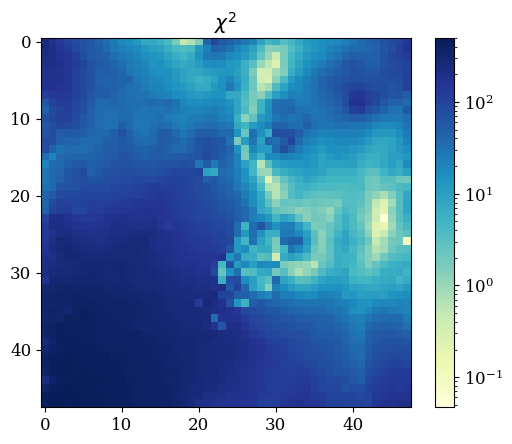

In [137]:
# fix mean with mean colors from i-band

index = np.random.randint(0, int(5e5))
print(index)
chi2 = chisq(fos[:,index], efos[:,index], fms)
im = chi2.reshape(n,n)
plt.imshow(im, norm=LogNorm(), cmap='YlGnBu')
plt.title(r'$\chi^2$')
plt.colorbar()

NameError: name 'p_z_Cs' is not defined

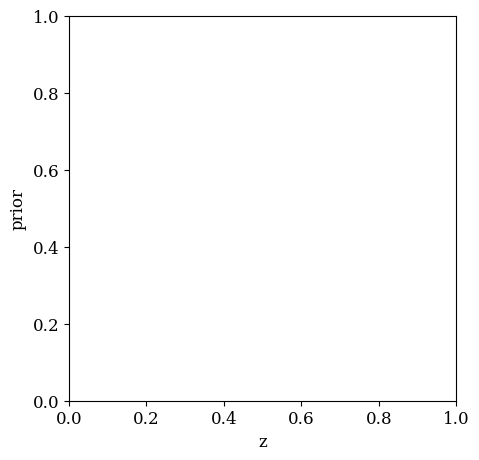

In [133]:
plt.figure(figsize=(5,5))
plt.xlabel('z')
plt.ylabel('prior')
plt.plot(np.linspace(0,3.5,1000), np.sum(p_C.reshape(n**2,1)*p_z_Cs, axis=0))
plt.show()

In [134]:
for index in np.random.randint(0, int(5e5), 10):
    chi2 = som.chisq(fluxes_d[index], fluxerrs_d[index])

    print(index)
    im = chi2.reshape(n,n)
    #plt.imshow(im, norm=LogNorm(), cmap='YlGnBu')
    #plt.colorbar()

    # getting p(C)

    z_counts = squares['Z']['good_len'].values
    p_C = z_counts/np.sum(z_counts) #capital C is c-hat
    ln_p_C = np.full_like(p_C, -300)
    ln_p_C[p_C>0]=np.log(p_C[p_C>0])

    #im = ln_p_C.reshape(n,n)
    #plt.imshow(im)
    #plt.colorbar()

    np.sum(lnposterior)

    plt.plot(np.linspace(0,3.5,100), lnposterior, label=f'ln posterior {index}')
    plt.xlabel('z')
    plt.ylabel('probability')
    #plt.plot(np.linspace(0,3.5,100), (-lnprior+lnprior.max())/np.sum(-lnprior+lnprior.max()), label=f'ln prior {index}')
    plt.legend()
plt.show()

138982


NameError: name 'lnposterior' is not defined

In [25]:
np.savetxt('%s/p_C_1st_attempt.txt'%path_data, p_C)
np.savetxt('%s/p_z_Cs_1st_attempt.txt'%path_data, p_z_Cs)

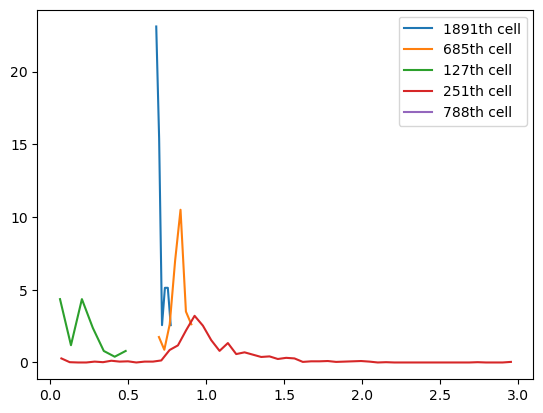

In [32]:
for i in np.random.randint(n**2, size=5):
    plt.plot(bins_c[i], bins_v[i], label=f'{i}th cell')
    plt.legend()
plt.show()

600


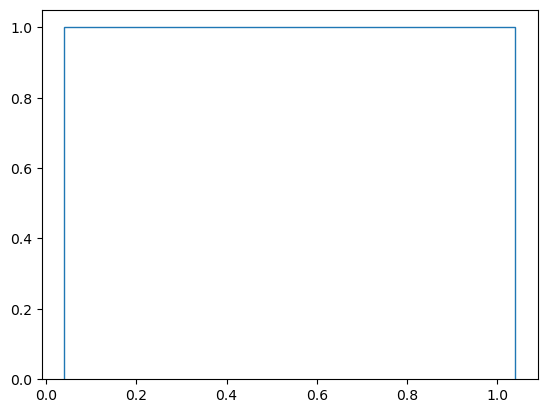

In [27]:
cell_no = np.random.randint(0,n**2)
print(cell_no)
h_bins, bins, patches = plt.hist(z_sample_cells[cell_no], histtype='step', density=True, bins='auto')
bin_c = [bins[i]+.5*(bins[i+1]-bins[i]) for i in range(len(bins)-1)]

plt.plot(bin_c, h_bins)

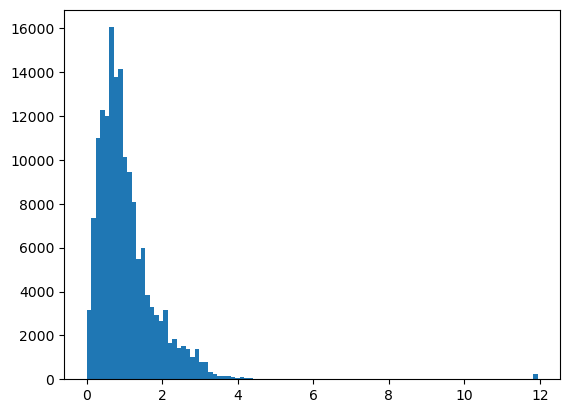

In [61]:
plt.hist(data['Z'], bins=100);

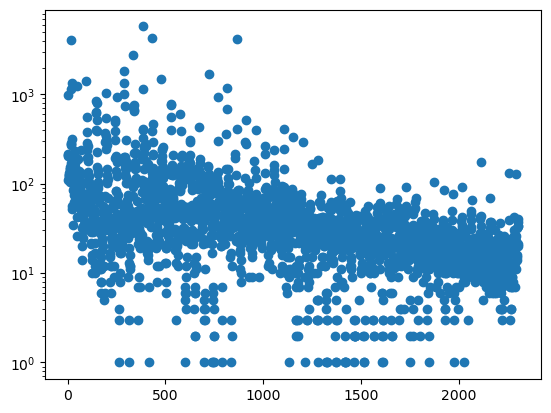

In [30]:
plt.scatter(range(n**2),z_counts)
plt.yscale('log')